# Integral Control Problem

$\newcommand{\d}{\text{d}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, trapezoid
from tqdm import tqdm
import os
import cvxpy as cp
from matplotlib import cm
from scipy.io import savemat, loadmat
import time

The model under consideration is, for $z\in\R^2$ with $n_u$ controllers located at $z_i\in\R^2$,

$$x^{t+1}(z) = \iint a(z-z') x^t(z') d z' + \sum_{i=1}^{n_u} b(i,z) u_i^t = A x^t + B u^t\,.$$

The dynamics for the closed-loop maps (CLMs) are
\begin{align*}
\theta_x^{t+1,\tau+1}(\tilde z, z) &= \iint a(z-z') \theta_x^{t,\tau}(\tilde z,z') d z' + (B\theta_u^{t,\tau}(\tilde z))(z) \\
\theta_x^{t,0}(\tilde z, z) &= \delta(\tilde z- z)
\end{align*}
where $\tilde z$ is the input, $z$ is the output. We use the cost function
\begin{align*}
J(\theta (\tilde z)) = \lVert \theta \rVert ^2_F = \sum_{t,\tau} \left( Q \iint |\theta_x^{t,\tau}(\tilde z,z) |^2 d \tilde z +  R |\theta_u^{t,\tau}(\tilde z)|^2  \right)\,,
\end{align*}
for some $R>0$, $Q\ge 0$.



In [2]:
# Parameters

#  domain
xmin = -2
xmax = 2
ymin = -2
ymax = 2

# period for basis functions
lambda_1 = 2*(xmax - xmin)
lambda_2 = 2*(ymax - ymin)

# matrix norm
p = 2

# time steps
T  = 5
dt = 0.1

# number of controllers
n_u      = 16 # select perfect square
sqrt_n_u = int(np.sqrt(n_u)) 

# number of basis functions for approximation
k = 12

# radius of support of a(z) and b(z)
r = 0.5

# cost function parameters
Q = 1
R = 0

# plot approximation of functions to compare with exact function
plot_approx = True

In [3]:
# plot contour
def plot_contour(f, xmin, xmax, ymin, ymax, title=""):
    x = np.linspace(xmin, xmax, 50)
    y = np.linspace(ymin, ymax, 50)
    X, Y = np.meshgrid(x, y)
    Z    = np.zeros(X.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            Z[i,j] = f(np.array([X[i,j], Y[i,j]]), np.array([0, 0]))
    plt.contourf(X, Y, Z, 100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.colorbar()
    plt.title(title)
    plt.show()

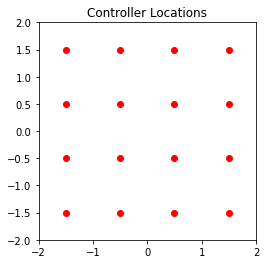

In [4]:
# locations of controllers evenly spaced in the domain not on the boundary
u_loc_x = np.round(np.linspace(xmin, xmax, sqrt_n_u + 1)[0:-1] + (xmax - xmin)/(2*sqrt_n_u) , 15)
u_loc_y = np.round(np.linspace(ymin, ymax, sqrt_n_u + 1)[0:-1] + (ymax - ymin)/(2*sqrt_n_u) , 15)
u_loc   = np.array([[x, y] for x in u_loc_x for y in u_loc_y])

# save uloc to file as npy
np.save('u_loc.npy', u_loc)

# plot domain with controller locations
plt.figure()
plt.plot(u_loc[:,0], u_loc[:,1], 'ro')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Controller Locations')
plt.show()

## Approximation with basis functions

$\renewcommand{\d}{\text{d}}$
We use real Fourier basis functions for $\theta_x$ and $\theta_u$. For $z=[z_1,z_2]$,
\begin{align*}
    \varphi_{mn1}(z) &= \sin\frac{2\pi m z_1}{\lambda_1} \sin \frac{2\pi n z_2}{\lambda_2} \\
    \varphi_{mn2}(z) &=  \cos\frac{2\pi m z_1}{\lambda_1} \sin \frac{2\pi  n z_2}{\lambda_2} \\
     \varphi_{mn3}(z) &=  \sin\frac{2\pi m z_1}{\lambda_1} \cos \frac{2\pi n z_2}{\lambda_2} \\
      \varphi_{mn4}(z) &=  \cos\frac{2\pi m z_1}{\lambda_1} \cos \frac{2\pi n z_2}{\lambda_2} \,.
\end{align*}
The approximations for $a$, $b$, and $\theta_x$ are
\begin{align*}
    a(z) &\approx \sum_{m,n=0}^k \sum_{i=1}^4 a_{mni} \varphi_{mni}(z) \,, \\
    b(z) &\approx \sum_{m,n=0}^k \sum_{i=1}^4 \begin{bmatrix}
         b_{mni l} \varphi_{mni}(z) \\ \vdots \\ b_{mni n_u} \varphi_{mni}(z)
    \end{bmatrix} \in \R^{n_u}\,, \\
    \theta_x^{t}(\tilde z,z) &\approx \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}(\tilde z) \varphi_{mni}(z)
\end{align*}
for coefficients $a_{mni},b_{mnil},\alpha_{mni}$ defined as
\begin{align*}
    a_{mni} &=\frac{\kappa}{\lambda_1 \lambda_2} \int_{-\lambda_2/2}^{\lambda_2/2} \int_{-\lambda_1/2}^{\lambda_1/2} a(z) \varphi_{mni}(z) \d z_1 \d z_2 \\
    b_{mnil} &=\frac{\kappa}{\lambda_1 \lambda_2} \int_{-\lambda_2/2}^{\lambda_2/2} \int_{-\lambda_1/2}^{\lambda_1/2} b(l,z) \varphi_{mni}(z) \d z_1 \d z_2\,,\\
    \kappa &= \begin{cases}
        1 & \text{if } m=0 \text{ and } n=0   \\
        2 & \text{if } m=0 \text{ or } n = 0 \\
        4 & \text{otherwise.}
    \end{cases}
\end{align*}

Note that this problem is input-separable (analagous to column-separable in finite dimensions) for a Frobenius norm cost function, so we can fix $\tilde z$ and solve for the operator in terms of $z$ only.

For implementation purposes, $\lambda_1$ and $\lambda_2$ must be at least twice the size of the domain in the $x$ and $y$ directions, respectively, to prevent aliasing.

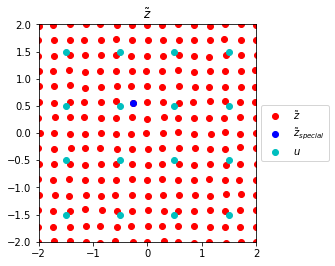

In [175]:
Nx = 15 # number of points in space to evaluate $\tilde{z}$
z_tilde_x = np.linspace(xmin, xmax, Nx) 
z_tilde_y = np.linspace(ymin, ymax, Nx) 
z_tilde   = np.array([[x+np.random.randn()*0.01,
                        y+np.random.randn()*0.01] for x in z_tilde_x for y in z_tilde_y])

# pick a specific point and highlight it
z_special = z_tilde[99]
# plot the points in space
plt.figure()
plt.plot(z_tilde[:,0], z_tilde[:,1], 'ro')
plt.plot(z_special[0],z_special[1], "bo")
# plot controllers
plt.plot(u_loc[:,0], u_loc[:,1], 'co')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\tilde{z}$')
# legend outside of plot
plt.legend([r'$\tilde{z}$', r'$\tilde{z}_{special}$', r'$u$'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



The function $a(z)$ is
\begin{align*}
    a(z) = \begin{cases}
    \frac{1}{2} + \frac{1}{2}\cos \frac{\pi \lVert z \rVert_2 }{r} & \text{ if } \lVert z \rVert_2 \le r \\
    0 & \text{otherwise.}
    \end{cases}
\end{align*}

Below, we numerically integrate to compute the coefficients $a_{mni}$. Because this takes some time, we save the coefficients so that we can load them instead of computing them in the future.

In [6]:
# function to approximate
def a(x, radius=r,p=p):
    mag_x = np.linalg.norm(x,p)
    if mag_x < radius:
        return 0.5*np.cos(np.pi*mag_x/radius) + 0.5
    else:
        return 0

# trig functions
def sin_sin_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.sin(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)

def cos_sin_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.cos(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)

def sin_cos_integrand_a(x1, x2 , i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.sin(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)

def cos_cos_integrand_a(x1, x2, i, j):
    x = np.array([x1, x2])
    return a(x, radius=r) * np.cos(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)


# compute coefficients if file doesn't exist
if not os.path.exists('coeffs_k{}_r05.npy'.format(k)):
    coeffs = np.zeros((k, k, 4))
    for kk in tqdm(range(k)):
        for jj in range((k)):
            if kk == 0 and jj == 0:
                kappa = 1
            elif kk == 0 or jj == 0:
                kappa = 2
            else:
                kappa = 4
            coeffs[kk, jj, 0] = dblquad(sin_sin_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 1] = dblquad(cos_sin_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 2] = dblquad(sin_cos_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)
            coeffs[kk, jj, 3] = dblquad(cos_cos_integrand_a, xmin, xmax, ymin, ymax, args=(kk, jj))[0] * kappa / (lambda_1 * lambda_2)

    np.save('coeffs_k{}_r05.npy'.format(k), coeffs)
else:
    coeffs = np.load('coeffs_k{}_r05.npy'.format(k))


Once we have computed the coefficients, we compare the exact and approximated versions of the function $a$. If we use more basis functions, that is, increase the parameter $k$, the approximation will be more accurate. For more details on how the error decreases with increasing $k$, see FILL IN.

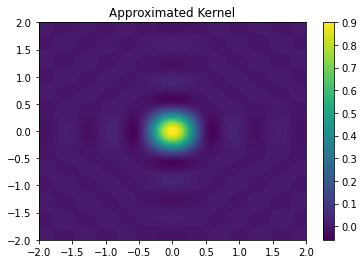

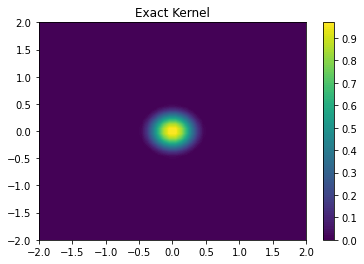

In [7]:
if plot_approx:
    def approx_a(x, coeffs, lambda_1=lambda_1, lambda_2=lambda_2,r=r):
        val = 0
        for i in range(k):
            for j in range(k):
                val += coeffs[i, j, 0] * np.sin(np.pi * 2*i * x[0] / lambda_1) * np.sin(np.pi * 2*j * x[1] / lambda_2) # / (lambda_1 * lambda_2)
                val += coeffs[i, j, 1] * np.cos(np.pi * 2*i * x[0] / lambda_1) * np.sin(np.pi * 2*j * x[1] / lambda_2) #/ (lambda_1 * lambda_2)
                val += coeffs[i, j, 2] * np.sin(np.pi * 2*i * x[0] / lambda_1) * np.cos(np.pi * 2*j * x[1] / lambda_2) #/ (lambda_1 * lambda_2)
                val += coeffs[i, j, 3] * np.cos(np.pi * 2*i * x[0] / lambda_1) * np.cos(np.pi * 2*j * x[1] / lambda_2) #/ (lambda_1 * lambda_2)
        return val

    # plot approximated function
    plot_contour(lambda x, x0: approx_a(x, coeffs), xmin, xmax, ymin, ymax, title="Approximated Kernel")

    # plot exact function
    plot_contour(lambda x, x0: a(x, radius=r), xmin, xmax, ymin, ymax, title="Exact Kernel")

Next we compute the coefficients for $b(z)$, which we select to be equal to
\begin{align*}
b(z) = \begin{bmatrix}
 -a(z-u_{loc}^{(1)}) \\
  \vdots \\
  -a(z-u_{loc}^{(n_u)})
\end{bmatrix}\,,
\end{align*}
where $u_{loc}^{(l)}$ is the location of the $l^{th}$ controller.
Since this function has $n_u$ components, it is slower to compute the coefficients than for $a(z)$, so we suggest running the file compute_b_coefficients_parallel.py which parallelizes the computation of the coefficients.

In [8]:
def b(z,loc,radius=r):
    return -a(z-loc,radius=radius)

# trig functions for b
def sin_sin_integrand(x1, x2, i, j):
    return np.sin(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)
def cos_sin_integrand(x1, x2, i, j):
    return np.cos(np.pi * 2*i * x1 / lambda_1) * np.sin(np.pi * 2*j * x2 / lambda_2)
def sin_cos_integrand(x1, x2 , i, j):
    return np.sin(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)
def cos_cos_integrand(x1, x2, i, j):
    return np.cos(np.pi * 2*i * x1 / lambda_1) * np.cos(np.pi * 2*j * x2 / lambda_2)

# check if coeffs_b_k{}.npy exists
if not os.path.exists('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u)):
    coeffs_b = np.zeros((k, k, 4, n_u))
    for kk in tqdm(range(k)):
        for jj in range((k)):
            if kk == 0 and jj == 0:
                kappa = 1
            elif kk == 0 or jj == 0:
                kappa = 2
            else:
                kappa = 4
            for controller in range(n_u):
                coeffs_b[kk, jj, 0, controller] = dblquad(lambda x1, x2: sin_sin_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 1, controller] = dblquad(lambda x1, x2: cos_sin_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 2, controller] = dblquad(lambda x1, x2: sin_cos_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)
                coeffs_b[kk, jj, 3, controller] = dblquad(lambda x1, x2: cos_cos_integrand(x1, x2, kk, jj) * b(np.array([x1, x2]), u_loc[controller], radius=r), xmin, xmax, ymin, ymax)[0] * kappa / (lambda_1 * lambda_2)

    np.save('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u), coeffs_b)

else: # if it exists, load it
    coeffs_b = np.load('coeffs_b_k{}_r05_nu{}.npy'.format(k,n_u))

In [9]:
# plot approximated control function for each controller
def approx_b(x, coeffs_b, lambda_1=lambda_1, lambda_2=lambda_2,r=r):
    val = 0
    for i in range(k):
        for j in range(k):
            val += coeffs_b[i, j, 0] * np.sin(np.pi * 2*i * x[0] / lambda_1) * np.sin(np.pi * 2*j * x[1] / lambda_2) 
            val += coeffs_b[i, j, 1] * np.cos(np.pi * 2*i * x[0] / lambda_1) * np.sin(np.pi * 2*j * x[1] / lambda_2) 
            val += coeffs_b[i, j, 2] * np.sin(np.pi * 2*i * x[0] / lambda_1) * np.cos(np.pi * 2*j * x[1] / lambda_2)
            val += coeffs_b[i, j, 3] * np.cos(np.pi * 2*i * x[0] / lambda_1) * np.cos(np.pi * 2*j * x[1] / lambda_2)
    return val


controller 0
controller 1
controller 2
controller 3
controller 4
controller 5
controller 6
controller 7
controller 8
controller 9
controller 10
controller 11
controller 12
controller 13
controller 14
controller 15


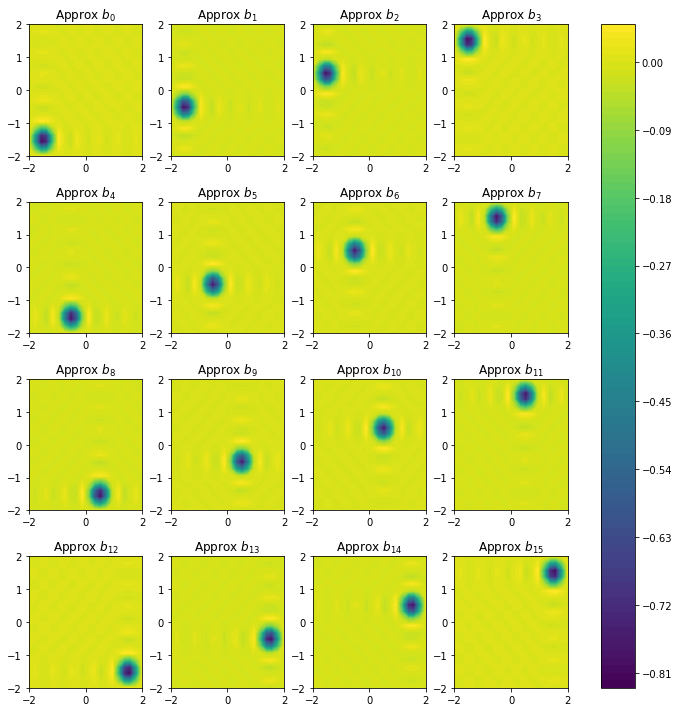

In [10]:
if plot_approx:
    # plot approximated control function for each controller
    fig, axs = plt.subplots(sqrt_n_u, sqrt_n_u, figsize=(10, 10))
    x = np.linspace(xmin, xmax, 20)
    y = np.linspace(ymin, ymax, 20)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(sqrt_n_u):
        for j in range(sqrt_n_u):
            idx =  i*sqrt_n_u + j
            print("controller", idx)
            for kk in range(X.shape[0]):
                for m in range(X.shape[1]):
                    Z[kk,m] = approx_b(np.array([X[kk,m], Y[kk,m]]), coeffs_b[:,:, :,idx])
            ax = axs[i, j]
            img = ax.contourf(X, Y, Z, 100)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_title('Approx $b_{'+str(int(i*sqrt_n_u + j))+'}$')
    plt.tight_layout()
    fig.colorbar(img, ax=axs.ravel().tolist())
    plt.show()


## Coefficient constraints

We use the system-level parameterization (SLP) to relate all of the coefficents and controller values. At time $t=0$, the first state response is 
\begin{align*}
\theta_x^{0}(\tilde z,z) = \delta(z-\tilde z)\,.
\end{align*}
The state response at time $t=1$, as specified by the SLP, is
\begin{align*}
\theta_x^{1}(\tilde z,z) &= \iint a(z-z') \theta_x^0(\tilde z,z') \d z + b(z)^\top \theta_u(\tilde z) \\
&= a(z-\tilde z) + b(z)^\top \theta_u(\tilde z)\,.
\end{align*}

Since $\theta_x^0(\tilde z,z)=\delta(z-\tilde z)$ is not a free variable, we start by parameterizing $\theta_z^1(\tilde z,z)$ in terms of $\theta_u^0(\tilde z)$. We will use the basis function approximation. We use the trigonometry identities
\begin{align*}
    \sin\frac{2\pi m}{\lambda_i}(z_i-\tilde{z}_i) &= \sin\frac{2\pi m}{\lambda_i}z_i \cos\frac{2\pi m}{\lambda_i}\tilde{z}_i-\cos\frac{2\pi m}{\lambda_i}z_i \sin\frac{2\pi m}{\lambda_i}\tilde{z}_i \\
    \cos\frac{2\pi m}{\lambda_i}(z_i-\tilde{z}_i) &= \cos\frac{2\pi m}{\lambda_i}z_i \cos\frac{2\pi m}{\lambda_i}\tilde{z}_i+\cos\frac{2\pi m}{\lambda_i}z_i \cos\frac{2\pi m}{\lambda_i}\tilde{z}_i
\end{align*}
to express $a(z-\tilde z)$ in terms of basis functions
\begin{align*}
    a(z-\tilde z) &\approx \sum_{m,n=0}^k \sum_{i=1}^4 a_{mni}\varphi_{mni}(z-\tilde z) \\
    &=\sum_{m,n=0}^k \sum_{i=1}^k \hat a_{mni}(\tilde z) \varphi_{mni}(z)\,.
\end{align*}
The coefficients $\hat a_{mni}$ are
\begin{align*}
    \hat a_{mni} = \begin{cases}
        a_{mn1} \varphi_4(\tilde z) + a_{mn2} \varphi_3(\tilde z) + a_{mn3}\varphi_2(\tilde z) + a_{mn4}\varphi_1(z) & \text{if } i=1 \\
        -a_{mn2} \varphi_3(\tilde z) + a_{mn2} \varphi_4(\tilde z) - a_{mn3}\varphi_1(\tilde z) + a_{mn4}\varphi_2(z) & \text{if } i=2 \\
        -a_{mn3} \varphi_2(\tilde z) - a_{mn2} \varphi_1(\tilde z) + a_{mn3}\varphi_4(\tilde z) + a_{mn4}\varphi_3(z) & \text{if } i=3 \\
        a_{mn4} \varphi_1(\tilde z) - a_{mn2} \varphi_2(\tilde z) - a_{mn3}\varphi_3(\tilde z) + a_{mn4}\varphi_4(z) & \text{if } i=4 \\
    \end{cases}\,.
\end{align*}

Therefore $\theta_x^{(1)}(\tilde z)$ is
\begin{align*}
\theta_x^1(\tilde z) = \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}^{(1)}(\tilde z) \varphi_{mni}(z) = \sum_{m,n=0}^k \sum_{i=1}^4 \left(\hat a_{mni}(\tilde z) + \sum_{l=1}^{n_u} b_{mnil} \theta_u^{(0)}(\tilde{z})_l \right) \varphi_{mni}(z)\,.
\end{align*}
Since this must hold for $z$ almost everywhere in the domain, the coefficients must satisfy
\begin{align}
\alpha_{mni}^{(1)}(\tilde z) - \hat a_{mni}(\tilde z) - \sum_{l=1}^{n_u} b_{mnil} \theta_u^{(0)}(\tilde{z})=0 \qquad \forall\, m,n\in[0,\dots,k]\,, \ i\in[4]\,. 
\end{align}

For all other time steps, the following parameterization holds:
\begin{align*}
\theta_x^{(t+1)}(\tilde z, z) &\approx \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}^{(t+1)}(\tilde z) \varphi_{mni}(z) \\
 &= \iint \left(\sum_{m,n=0}^k \sum_{i=1}^4 a_{mni} \varphi_i(z-z')\right)\left( \sum_{\hat m,\hat n=0}^k \sum_{\hat i=1}^4 \alpha_{\hat m \hat n \hat i}^{(t)}(\tilde z) \varphi_{\hat m \hat n \hat i}(z') \right) \d z' + b(z)^\top \theta_u^{(t)}(\tilde z) \,.
\end{align*}
Since the basis functions are orthogonal for $(m,n,i) \ne (\hat m, \hat n,\hat i)$ for the domain over which the integral is defined, only the $(m,n,i) = (\hat m, \hat n,\hat i)$ terms are nonzero:

\begin{align*}
 \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}^{(t+1)}(\tilde z) \varphi_{mni}(z) &= \sum_{m,n=0}^k \sum_{i=1}^4  \iint a_{mni}  \varphi_{mni}(z-z')  \alpha_{m  n i}^{(t)}(\tilde z) \varphi_{ mni}(z') \d z' + b(z)^\top \theta_u^{(t)}(\tilde z)  \\
 &= \sum_{m,n=0}^k \sum_{i=1}^4 a_{mni} \alpha_{m  n i}^{(t)}(\tilde z) \iint   \varphi_{mni}(z-z')   \varphi_{ mni}(z') \d z' + b(z)^\top \theta_u^{(t)}(\tilde z)  \,.
\end{align*}

A character-building computation, which can be done with software such as Mathematica, reduces the integral
\begin{align*}
    \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}^{(t+1)}(\tilde z) \varphi_{mni}(z) &= 
    \sum_{m,n=0}^k \sum_{i=1}^4 4 \lambda_1 \lambda_2 \bar A_{mn}[i,:] \alpha_{m  n}^{(t)}(\tilde z) \varphi_{mn i}(z)  + b(z)^\top \theta_u^{(t)}(\tilde z)  \,,
\end{align*}
where $\bar A_{mn}$, $\alpha_{mn}^{(t)}$ are given by
\begin{align*}
    \bar A_{mn} = \begin{bmatrix}
                    a_{mn4} & a_{mn3} & a_{mn2} & a_{mn1} \\
                    -a_{mn3} & a_{mn4} & -a_{mn1} & a_{mn2} \\
                    -a_{mn2} & -a_{mn1} & a_{mn4} & a_{mn3} \\
                    a_{mn1} & -a_{mn2} & -a_{mn3} & a_{mn4} 
                \end{bmatrix}\,, \qquad 
    \alpha_{mn}^{(t)}(\tilde z) = \begin{bmatrix} 
        \alpha_{mn1}^{(t)}(\tilde z) \\ \alpha_{mn2}^{(t)}(\tilde z) \\ \alpha_{mn3}^{(t)}(\tilde z) \\ \alpha_{mn4}^{(t)}(\tilde z)
                        \end{bmatrix} \,.
\end{align*}
Since this also must hold for $z$ almost everywhere in the domain, the constraint can be written in terms of coefficients
\begin{align}
      \alpha_{mni}^{(t+1)}(\tilde z) -  4 \lambda_1 \lambda_2 \bar A_{mn}[i,:] \alpha_{m  n}^{(t)}(\tilde z)  - \sum_{l=1}^{n_u} b_{mnil} \theta_u^{(t)}(\tilde{z})_l  = 0 \qquad \forall\, m,n\in [0,\dots,k]\,,  i\in[4] \,, \tag{2}
\end{align}

Equations (1) and (2) are implemented below.


In [176]:
start_time = time.time() # time controller synthesis process
z          = z_tilde[99] # select a specific z_tilde
print("disturbance at z_tilde", z)

alpha   = cp.Variable((T,k*k*4))
utilde  = cp.Variable((T,n_u))

# round coeffs and coeffs_b to 15 decimal places
coeffs   = np.round(coeffs, 15) # a_{mni}
coeffs_b = np.round(coeffs_b, 15) # b_{mnil}

# constraints
constraints = []

for m in range(k):
    for n in range(k):
        # (m,n)^th basis function
        sinsin = np.sin(np.pi * 2*m * z[0] / lambda_1) * np.sin(np.pi * 2*n * z[1] / lambda_2) 
        cossin = np.cos(np.pi * 2*m * z[0] / lambda_1) * np.sin(np.pi * 2*n * z[1] / lambda_2) 
        sincos = np.sin(np.pi * 2*m * z[0] / lambda_1) * np.cos(np.pi * 2*n * z[1] / lambda_2)
        coscos = np.cos(np.pi * 2*m * z[0] / lambda_1) * np.cos(np.pi * 2*n * z[1] / lambda_2) 
        current_idx_set = np.arange(m*k*4 + n*4, m*k*4 + n*4 + 4)
        for i in range(4): # each type of trig function combination
            idx = m*k*4 + n*4 + i
            sublist = []
            ################################ initial condition ################################
            initial_coeff = 0
            if i==0:
                # sin(z[0])sin(z[1])
                initial_coeff = coscos*coeffs[m,n,0] + sincos*coeffs[m,n,1] + cossin*coeffs[m,n,2] + sinsin*coeffs[m,n,3]
            elif i==1:
                # cos(z[0])sin(z[1])
                initial_coeff = -sincos*coeffs[m,n,0] + coscos*coeffs[m,n,1] - sinsin*coeffs[m,n,2] + cossin*coeffs[m,n,3]
            elif i==2:
                # sin(z[0])cos(z[1])
                initial_coeff = -cossin*coeffs[m,n,0] - sinsin*coeffs[m,n,1] + coscos*coeffs[m,n,2] + sincos*coeffs[m,n,3]
            else:
                # cos(z[0])cos(z[1])
                initial_coeff = sinsin*coeffs[m,n,0] - cossin*coeffs[m,n,1] - sincos*coeffs[m,n,2] + coscos*coeffs[m,n,3]
                
            sublist  += [coeffs_b[m,n,i,:] @ utilde[0,:] + np.copy(initial_coeff) == alpha[0,idx]]
            ######################################################################################


            ################################ dynamics ################################
            # \[Pi] (\[Pi] Sin[v] ((-b f-a g+d h+c j) Cos[z]+(d f+c g+b h+a j) Sin[z])+\[Pi] Cos[v] ((a f-b g-c h+d j) Cos[z]+(-c f+d g-a h+b j) Sin[z])) 
            for t in range(T-1):
                new_coeff = 0
                if i==0: # sin(z[0])sin(z[1])    (d f+c g+b h+a j)
                    new_coeff = coeffs[m,n,3]*alpha[t,current_idx_set[0]] + coeffs[m,n,2]*alpha[t,current_idx_set[1]] + coeffs[m,n,1]*alpha[t,current_idx_set[2]] + coeffs[m,n,0]*alpha[t,current_idx_set[3]]
                elif i==1: # cos(z[0])sin(z[1])    (-c f+d g-a h+b j)
                    new_coeff = -coeffs[m,n,2]*alpha[t,current_idx_set[0]] + coeffs[m,n,3]*alpha[t,current_idx_set[1]] - coeffs[m,n,0]*alpha[t,current_idx_set[2]] + coeffs[m,n,1]*alpha[t,current_idx_set[3]]
                elif i==2: # sin(z[0])cos(z[1])    (-b f-a g+d h+c j)
                    new_coeff = -coeffs[m,n,1]*alpha[t,current_idx_set[0]] - coeffs[m,n,0]*alpha[t,current_idx_set[1]] + coeffs[m,n,3]*alpha[t,current_idx_set[2]] + coeffs[m,n,2]*alpha[t,current_idx_set[3]]
                else: # cos(z[0])cos(z[1])    (a f-b g-c h+d j)
                    new_coeff = coeffs[m,n,0]*alpha[t,current_idx_set[0]] - coeffs[m,n,1]*alpha[t,current_idx_set[1]] - coeffs[m,n,2]*alpha[t,current_idx_set[2]] + coeffs[m,n,3]*alpha[t,current_idx_set[3]]
                
                sublist += [alpha[t+1,idx] - lambda_1*lambda_2/4* new_coeff- coeffs_b[m,n,i,:] @ utilde[t+1,:] == 0]
            ###############################################################################

            
            constraints += [sublist]
    


disturbance at z_tilde [-0.2636686  0.559292 ]


### Optimization Problem

The optimization problem we would like to solve, written in terms of the basis functions, is
\begin{align*}
J(\theta (\tilde z)) & = \sum_{t=0}^T \left( Q \iint |\theta_x^{(t)}(\tilde z,z) |^2 d \tilde z +  R |\theta_u^{(t)}(\tilde z)|^2  \right) \\
                     & \approx \sum_{t=0}^T \left( Q \iint \left| \sum_{m,n=0}^k \sum_{i=1}^4 \alpha_{mni}^{(t)} \varphi_{mni}(z) \right |^2 d \tilde z +  R |\theta_u^{(t)}(\tilde z)|^2  \right) \,,
\end{align*}
and since the basis functions are orthonormal, the cost can be written in terms of the coefficients $\alpha_{mni}^{(t)}$:
\begin{align*}
J(\theta_u(\tilde z),\alpha) \approx \sum_{t=0}^T \sum_{m,n=0}^k \sum_{i=1}^4  \left( Q  (\alpha_{mni}^{(t)})^2  +  R |\theta_u^{t,\tau}(\tilde z)|^2  \right) \,.
\end{align*}
The optimization problem that we solve is
\begin{align*}
\argmin_{\theta_u(\tilde z),\alpha} J(\theta_u(\tilde z),\alpha) \qquad \text{s.t. } (1),(2) \text{ hold.}
\end{align*}

In [177]:
# optimize over the sum of squares of alpha and utilde

# concatente all constraints for new variable
global_constraints = [item for sublist in constraints for item in sublist]
objective = cp.Minimize(Q*cp.sum_squares(alpha) + R*cp.sum_squares(utilde)) 
prob = cp.Problem(objective, global_constraints)

# use MOSEK if installed
if "MOSEK" in cp.installed_solvers():
    prob.solve(solver=cp.MOSEK,verbose=False)
else:
    prob.solve(verbose=False)

# print time required to solve
print("Time to solve: ", time.time() - start_time)

# print status of solve
print(prob.status)

Time to solve:  8.604806900024414
optimal


In [178]:
# print optimal value and control value
print("Optimal Cost",prob.value)
print("control inputs",utilde.value)


Optimal Cost 0.004409941497189518
control inputs [[ 3.81504599e-05  4.41106199e-04 -2.92603737e-02  3.14076409e-04
   9.43607320e-04 -2.54606033e-03  6.54627833e-01  1.41510194e-03
  -6.49347492e-05  2.39250897e-04 -1.98909736e-02  3.05660767e-04
  -1.17459185e-05  5.34981442e-05 -1.09401958e-02 -5.42537144e-05]
 [ 2.46614199e-05 -4.13580741e-05 -1.07791180e-04 -4.60464961e-05
  -5.53466222e-04 -3.65116150e-04  1.02356849e-02 -4.06132814e-04
  -1.05175783e-04 -1.84192007e-04  4.72645198e-03 -1.80297171e-04
   7.79709608e-05  8.94598307e-05 -1.92988407e-03  9.10189306e-05]
 [ 1.31004717e-05  2.09643347e-05 -2.35332841e-04 -2.97835199e-06
  -9.91234352e-05 -1.58191004e-04  1.40025679e-03  7.75744294e-05
  -7.12985580e-05 -7.15603976e-05  1.21229855e-03 -7.26114162e-05
   1.23506607e-05  1.24943646e-05 -1.75693750e-04 -7.83876731e-06]
 [ 4.45880058e-06  5.39632748e-06 -6.19485045e-05 -1.91436010e-06
  -1.74695881e-05 -3.03898055e-05  2.24357286e-04  3.50134702e-05
  -1.98857665e-05 -1.260

In [179]:
# reshape parameters
alpha_parsed = alpha.value.reshape((T,k,k,4), order='C')

# compute the approximation of the function at z_tilde
x = np.linspace(xmin, xmax, 50)
y = np.linspace(ymin, ymax, 50)
X, Y = np.meshgrid(x, y)
Z = np.zeros((T, X.shape[0], X.shape[1]))
for tt in range(T):
    for i in range(k):
        for j in range(k):
            for m in range(X.shape[0]):
                for n in range(X.shape[1]):
                    Z[tt,m,n] += alpha_parsed[tt,i,j,0] * np.sin(np.pi * 2*i * X[m,n] / lambda_1) * np.sin(np.pi * 2*j * Y[m,n] / lambda_2) 
                    Z[tt,m,n] +=  alpha_parsed[tt,i,j,1] * np.cos(np.pi * 2*i * X[m,n] / lambda_1) * np.sin(np.pi * 2*j * Y[m,n] / lambda_2) 
                    Z[tt,m,n] +=  alpha_parsed[tt,i,j,2] * np.sin(np.pi * 2*i * X[m,n] / lambda_1) * np.cos(np.pi * 2*j * Y[m,n] / lambda_2) 
                    Z[tt,m,n] += alpha_parsed[tt,i,j,3] * np.cos(np.pi * 2*i * X[m,n] / lambda_1) * np.cos(np.pi * 2*j * Y[m,n] / lambda_2) 



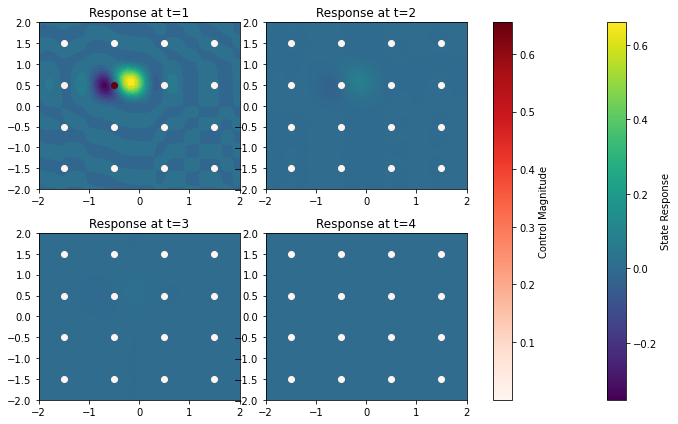

In [180]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
cmin = np.min(Z)
cmax = np.max(Z)
control_max = np.max(np.abs(utilde.value))
control_min = np.min(np.abs(utilde.value))
# color-code controllers by magnitude
cmap = cm.get_cmap('Reds')
control_colors = np.zeros_like(utilde.value)
for control_index in range(n_u):
    for t in range(T):
        control_colors[t,control_index] = (np.abs(utilde.value[t,control_index])-control_min)/(control_max-control_min)

# four subplots with first 4 time steps
for ii in range(2):
    for jj in range(2):
        ax = axs[ii, jj]
        img = ax.contourf(X, Y, Z[ii*2+jj,:,:], 25, vmin=cmin, vmax=cmax)
        for controller in range(n_u):
            ax.plot(u_loc[controller,0], u_loc[controller,1], 'o', color=cmap(control_colors[ii*2+jj,controller]))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title('Response at t='+str(ii*2+jj+1))
plt.tight_layout()
# set colorbar for the state response
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cb1 = plt.colorbar(sm, ax=axs.ravel().tolist())
cb1.set_label('State Response')
# set colorbar for the controllers
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=control_min, vmax=control_max))
sm.set_array([])
cb2 = plt.colorbar(sm, ax=axs.ravel().tolist())
cb2.set_label('Control Magnitude')
plt.show()


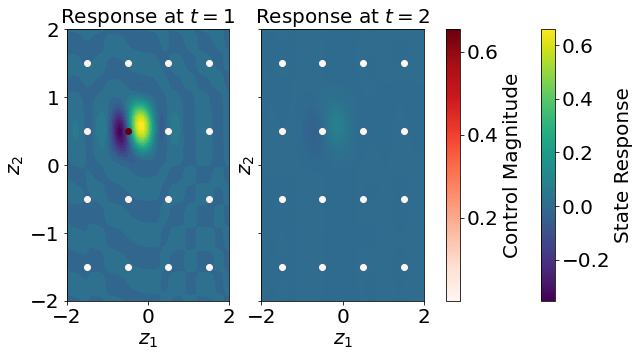

In [181]:
fontsize = 20
# plot just first two time steps
fig, axs = plt.subplots(1, 2, figsize=(10, 5),sharey=True)
ax = axs[0]
img = ax.contourf(X, Y, Z[0,:,:], 25, vmin=cmin, vmax=cmax)
for controller in range(n_u):
    ax.plot(u_loc[controller,0], u_loc[controller,1], 'o', color=cmap(control_colors[0,controller]))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r"$z_1$", fontsize=fontsize)
ax.set_ylabel(r"$z_2$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('Response at $t=1$', fontsize=fontsize)
ax = axs[1]
img = ax.contourf(X, Y, Z[1,:,:], 25, vmin=cmin, vmax=cmax)
for controller in range(n_u):
    ax.plot(u_loc[controller,0], u_loc[controller,1], 'o', color=cmap(control_colors[1,controller]))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r"$z_1$", fontsize=fontsize)
ax.set_ylabel(r"$z_2$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('Response at $t=2$', fontsize=fontsize)
# set colorbar for the state response
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cb1 = plt.colorbar(sm, ax=axs.ravel().tolist())
cb1.set_label('State Response', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize)
# set colorbar for the controllers
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=control_min, vmax=control_max))
sm.set_array([])
cb2 = plt.colorbar(sm, ax=axs.ravel().tolist())
cb2.set_label('Control Magnitude',  fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize)
plt.savefig('response.png', bbox_inches='tight')
plt.show()

## Exact Solution Using Integrators

To verify if the approximated solution is accurate, we compute the actual state with the same initial condition and controllers using numerical integration.

In [182]:
X = np.linspace(xmin, xmax, 50)
Y = np.linspace(ymin, ymax, 50)
def x1_exact(x,y,z):
    return a(np.array([x,y])-z, radius=r) + np.sum([b(np.array([x,y]),u_loc[i])*utilde.value[0,i] for i in range(n_u)])

def xt_exact(x,y,lastX,control):
    return trapezoid(trapezoid(np.array([[a(np.array([x,y])-np.array([x1,y1]), radius=r)*lastX[i,j] for j,y1 in enumerate(Y)] for i,x1 in enumerate(X)]), Y), X) + \
            np.sum([b(np.array([x,y]),u_loc[i])*control[i] for i in range(n_u)])

X1 = np.zeros((X.shape[0], Y.shape[0]))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        X1[i,j] = x1_exact(X[i], Y[j], z)


trueState = np.zeros((T, X.shape[0], Y.shape[0]))
trueState[0,:,:] = X1
for tt in tqdm(range(T-1)):
    # compute exact state response at time t+1
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            trueState[tt+1,i,j] = xt_exact(X[i], Y[j], trueState[tt], utilde.value[tt+1,:])



100%|██████████| 4/4 [02:15<00:00, 33.76s/it]


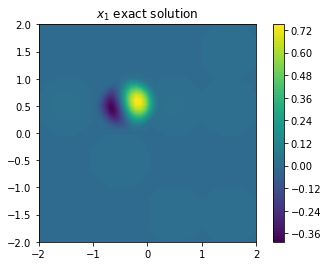

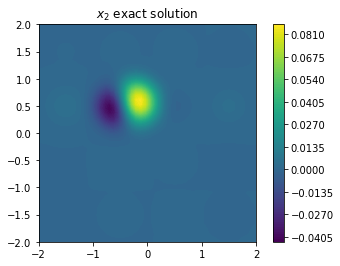

t=1: percent 2-norm state error 0.16
t=2: percent 2-norm state error 0.107
t=3: percent 2-norm state error 0.165
t=4: percent 2-norm state error 0.209
t=5: percent 2-norm state error 0.239


In [183]:
dx = (xmax - xmin) / (X.shape[0] - 1)
dy = (ymax - ymin) / (Y.shape[0] - 1)
plt.figure()
plt.contourf(X, Y, X1.T, 100)
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$x_1$ exact solution')

if T>1:
    plt.figure()
    plt.contourf(X, Y, trueState[1,:,:].T , 100)
    plt.colorbar()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(r'$x_2$ exact solution')
plt.show()

# compute error at each time step
errors = np.zeros(T)
for t in range(T):
    errors[t] = np.linalg.norm(trueState[t,:,:]-Z[t,:,:].T,"fro")*dx*dy / np.linalg.norm(trueState[t,:,:],"fro")
    print("t={}: percent 2-norm state error".format(t+1), np.round(errors[t]*100,3))

# print total error
# print("Total Error", np.sum(errors))

### Comparison with no control

In this setting, we compare the setting in which there is no control with the exact solution with control, in order to understand the impact of the control on the state evolution.

In [184]:
# no control, exact solution
X = np.linspace(xmin, xmax, 50)
Y = np.linspace(ymin, ymax, 50)
def x1_no_control(x,y,z):
    return a(np.array([x,y])-z, radius=r)

def xt_no_control(x,y,lastX):
    return trapezoid(trapezoid(np.array([[a(np.array([x,y])-np.array([x1,y1]), radius=r)*lastX[i,j] for j,y1 in enumerate(Y)] for i,x1 in enumerate(X)]), Y), X)

X1_no_control = np.zeros((T,X.shape[0], Y.shape[0]))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        X1_no_control[0,i,j] = x1_no_control(X[i], Y[j], z)

for tt in tqdm(range(T-1)):
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            X1_no_control[tt+1,i,j] = xt_no_control(X[i], Y[j], X1_no_control[tt])


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [02:13<00:00, 33.33s/it]


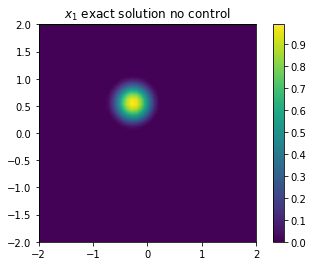

t= 1 cost without control 1.35E-01
t= 2 cost without control 3.88E-03
t= 3 cost without control 1.43E-04
t= 4 cost without control 5.91E-06
t= 5 cost without control 2.59E-07

 Total cost without control 1.39E-01 

t= 1 cost with control 7.82E-02
t= 2 cost with control 1.50E-03
t= 3 cost with control 4.17E-05
t= 4 cost with control 1.34E-06
t= 5 cost with control 4.62E-08

 Total cost with control 7.98E-02 

Percentage improvement due to control 42.79 %


In [185]:
plt.figure()
plt.contourf(X, Y, X1_no_control[0,:,:].T, 100)
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$x_1$ exact solution no control')
plt.show()

cost_no_control = 0
for tt in range(T):
    cost_t = np.linalg.norm( X1_no_control[tt], "fro")**2*dx*dy
    print("t=",tt+1, "cost without control", '%.2E' % cost_t)
    cost_no_control += cost_t

print("\n Total cost without control", '%.2E' % cost_no_control,"\n")

# compute cost with control from the exact solution
cost_with_control = 0
for tt in range(T):
    cost_t = np.linalg.norm(trueState[tt], "fro")**2*dx*dy
    print("t=",tt+1, "cost with control", '%.2E' % cost_t)
    cost_with_control += cost_t
print("\n Total cost with control", '%.2E' % cost_with_control,'\n')

# percentage improvement due to control
print("Percentage improvement due to control", np.round((cost_no_control-cost_with_control)/cost_no_control*100,2),"%")

In [186]:
# compute percentage improved for each time step due to control
for tt in range(T):
    print("t=",tt+1, "percentage improvement due to control",
           np.round((np.linalg.norm(X1_no_control[tt], "fro")**2 - np.linalg.norm(trueState[tt], "fro")**2)
                    /np.linalg.norm(X1_no_control[tt], "fro")**2*100,2),"%")

t= 1 percentage improvement due to control 42.23 %
t= 2 percentage improvement due to control 61.23 %
t= 3 percentage improvement due to control 70.93 %
t= 4 percentage improvement due to control 77.39 %
t= 5 percentage improvement due to control 82.16 %


Lastly, in order to compare with finite-dimensional SLS, we compute an approximation operator for $A$ and $B$.

points shape (400, 2)


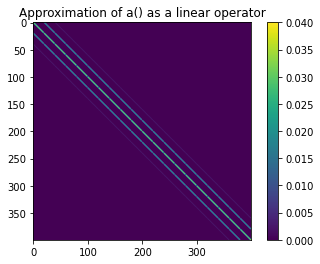

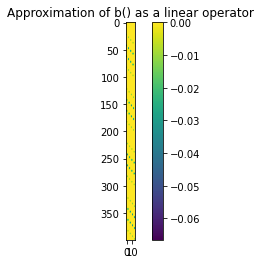

In [187]:
# compute approximation of a() as a linear operator over the domain with grid size dx_discretization
dx_discretization = 0.2
x = np.arange(xmin, xmax, dx_discretization)
y = np.arange(ymin, ymax, dx_discretization)
X, Y = np.meshgrid(x, y)
# location of all points in a list
points = np.array([[X[ii, jj], Y[ii, jj]] for ii in range(X.shape[0]) for jj in range(X.shape[1])])
print("points shape", points.shape)
A = np.zeros((points.shape[0], points.shape[0]))
for ii in range(points.shape[0]):
    for jj in range(points.shape[0]):
        A[ii, jj] = a(points[ii]-points[jj], radius=r) * dx_discretization**2

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.title("Approximation of a() as a linear operator")

# save A to a file
np.save('A_dx{}.npy'.format(dx_discretization), A)
savemat('A_dx{}.mat'.format(dx_discretization), {'A': A})

# now approximate b() as a linear operator
B = np.zeros((points.shape[0], n_u))
for ii in range(points.shape[0]):
    for jj in range(n_u):
        B[ii, jj] = b(points[ii], u_loc[jj], radius=r)*dx

plt.figure()
plt.imshow(B)
plt.colorbar()
plt.title("Approximation of b() as a linear operator")
plt.show()

# save B to a file
np.save('B_dx{}.npy'.format(dx_discretization), B)
savemat('B_dx{}.mat'.format(dx_discretization), {'B': B})

In [188]:
# load A and B from file
A = np.load('A_dx{}.npy'.format(dx_discretization))
B = np.load('B_dx{}.npy'.format(dx_discretization))

print("A shape", A.shape)
print("B shape", B.shape)

A shape (400, 400)
B shape (400, 16)


## Load results from ODE version of files

See ** file on the repository.

In [1]:
dx_values = [0.1, 0.2, 0.25, 0.5]
N_dx      = len(dx_values)
res       = {}
x_size    = []
for idx in range(N_dx):
    dx = dx_values[idx]
    phi_x = loadmat("dx"+ str(dx).replace(".","_") + ".mat" )["Phi_x"]
    x_size.append(phi_x.shape[0])
    res["phi_x_dx"+str(dx)] = phi_x
    phi_u = loadmat("dx"+ str(dx).replace(".","_") + ".mat" )["Phi_u"]
    res["phi_u_dx"+str(dx)] = phi_u



NameError: name 'loadmat' is not defined

In [190]:
# look at the first block column since the only disturbance is at t=0
phi_x_first_col = [res["phi_x_dx"+str(dx_values[dx_idx])][:,:int(x_size[dx_idx]/T)] for dx_idx in range(N_dx)]
phi_u_first_col = [res["phi_u_dx"+str(dx_values[dx_idx])][:,:int(x_size[dx_idx]/T)] for dx_idx in range(N_dx)]

### Compute Exact System With ODE Controller

In [191]:
X = np.linspace(xmin, xmax, 50)
Y = np.linspace(ymin, ymax, 50)
Z_ODE_control = np.zeros((T, N_dx, X.shape[0], Y.shape[0])) 
dx_idx_list   = []
for dx_idx in range(N_dx):
    # construct array of points
    x1 = np.arange(xmin, xmax, dx_values[dx_idx])
    y1 = np.arange(ymin, ymax, dx_values[dx_idx])
    X1, Y1 = np.meshgrid(x1, y1)
    points = np.array([[X1[ii, jj], Y1[ii, jj]] for ii in range(X1.shape[0]) for jj in range(X1.shape[1])])

    # get index of disturbance
    dist_to_z = np.linalg.norm(points - z,ord=2,axis=1)
    min_dist  = np.min(dist_to_z)
    z_index = np.where(dist_to_z==min_dist)
    dx_idx_list.append(z_index)

    control_values = phi_u_first_col[dx_idx][:,z_index].reshape((T,n_u)) / dx_values[dx_idx]**2 # rescale Dirac based on discretization


    def x1_exact(x,y,z):
        return a(np.array([x,y])-z, radius=r) + np.sum([b(np.array([x,y]),u_loc[i])*control_values[0,i] for i in range(n_u)])
        

    # initial condition
    X1 = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            X1[i,j] = x1_exact(X[i], Y[j], z)


    Z_ODE_control[0,dx_idx,:,:] = X1
    for tt in tqdm(range(T-1)):
        # compute exact state response at time t+1
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                Z_ODE_control[tt+1,dx_idx,i,j] = xt_exact(X[i], Y[j], Z_ODE_control[tt,dx_idx], control_values[tt+1,:])





phi_u shape (80, 1600)
phi_x shape (8000, 1600)


100%|██████████| 4/4 [02:20<00:00, 35.13s/it]


phi_u shape (80, 400)
phi_x shape (2000, 400)


100%|██████████| 4/4 [02:21<00:00, 35.42s/it]


phi_u shape (80, 256)
phi_x shape (1280, 256)


100%|██████████| 4/4 [02:19<00:00, 34.99s/it]


phi_u shape (80, 64)
phi_x shape (320, 64)


100%|██████████| 4/4 [02:21<00:00, 35.46s/it]


In [192]:
# compute state norm and error at each time step
dx = (xmax - xmin) / (X.shape[0] - 1)
dy = (ymax - ymin) / (Y.shape[0] - 1)
state_norms = np.zeros((N_dx,T))
for dx_idx in range(N_dx):
    # print("dx",dx_values[dx_idx])
    for t in range(T):
        state_norms[dx_idx,t] += np.linalg.norm(Z_ODE_control[t,dx_idx,:,:],"fro")**2*dx*dy
    
# compute overall improvement for each dx
print("Percentage improvement due to control", np.round((cost_no_control-np.sum(state_norms,axis=1))/cost_no_control*100,2),"%")

Percentage improvement due to control [36.26 30.54 31.91 37.36] %


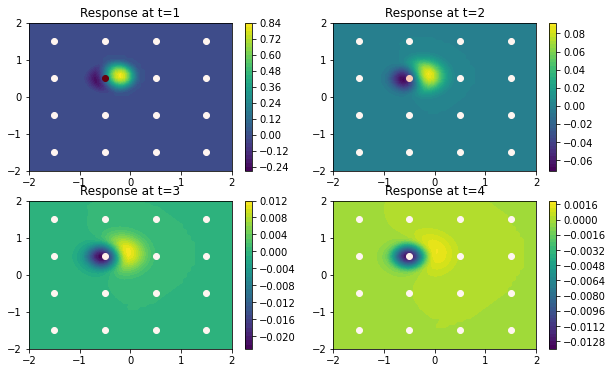

In [193]:
dx_idx = 0
state_size     = int(np.sqrt(phi_x_first_col[dx_idx].shape[0]/T))
state_response = phi_x_first_col[dx_idx][:,dx_idx_list[dx_idx]].reshape((T,state_size,state_size))/dx_values[dx_idx]**2
# X = np.linspace(xmin, xmax, state_size)
# Y = np.linspace(ymin, ymax, state_size)
X = np.linspace(xmin, xmax, 50)
Y = np.linspace(ymin, ymax, 50)

# plot state response
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
control_max = np.max(np.abs(control_values))
control_min = np.min(np.abs(control_values))
# color-code controllers by magnitude
cmap = cm.get_cmap('Reds')
control_colors = np.zeros_like(control_values)
for control_index in range(n_u):
    for t in range(T):
        control_colors[t,control_index] = (np.abs(control_values[t,control_index])-control_min)/(control_max-control_min)

# four subplots with first 4 time steps
for ii in range(2):
    for jj in range(2):
        ax = axs[ii, jj]
        img = ax.contourf(X, Y, Z_ODE_control[ii*2+jj,3,:,:].T, state_size,origin='lower')    
        plt.colorbar(img, ax=ax)
        for controller in range(n_u):
            ax.plot(u_loc[controller,0], u_loc[controller,1], 'o', color=cmap(control_colors[ii*2+jj,controller]))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title('Response at t='+str(ii*2+jj+1))